In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.7 MB/s e

In [ ]:
import os
import numpy as np
import cv2                     # OpenCV for Canny edge detection
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import PIL.Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

In [ ]:
config = {
    "batch_size": 256,       # how many image pairs per gradient step
    "lr": 2e-4,              # learning rate for both G and D (Adam)
    "betas": (0.5, 0.999),   # Adam momentum terms
    "num_epochs": 60,       # total training epochs
    "lambda_L1": 100.0,      # weight for L1 reconstruction loss vs GAN loss
    "device": "cuda" if torch.cuda.is_available() else "cpu",  # use GPU if available
    "save_every": 3,        # save sample grids every N epochs
    "data_root": "./data"    # where CIFAR‑10 will download / live
}
print(config)

{'batch_size': 256, 'lr': 0.0002, 'betas': (0.5, 0.999), 'num_epochs': 60, 'lambda_L1': 100.0, 'device': 'cpu', 'save_every': 3, 'data_root': './data'}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

# Specify the source and destination paths
source_path = 'checkpoints'  # Path to your checkpoint folder
destination_path = '/content/drive/My Drive/Colab Notebooks/checkpoints'  # Destination path in Drive

# Copy the checkpoint folder
shutil.copytree(source_path, destination_path)

'/content/drive/My Drive/Colab Notebooks/checkpoints'

In [ ]:
import shutil

def save_checkpoint_to_drive(source_path, destination_path):
    shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
save_checkpoint_to_drive('checkpoints', '/content/drive/My Drive/Colab Notebooks/checkpoints')



In [ ]:
save_checkpoint_to_drive('checkpoints',)

In [ ]:
class SketchCIFAR10(Dataset):
    def __init__(self, root, train=True):
        self.base = datasets.CIFAR10(root, train=train, download=True)
        self.transform_rgb = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # map to [-1,1]
        ])
        self.transform_edge = transforms.Compose([
            transforms.ToTensor()  # will convert single‑channel edge map to [0,1]
        ])

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]              # ignore class label
        gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 170, 300)    # thresholds = 100/200
        edges = cv2.bitwise_not(edges)       # invert so edges are black on white (optional)
        edge_img = self.transform_edge(edges)
        rgb_img = self.transform_rgb(img)
        return edge_img, rgb_img

# Instantiate loaders
train_set = SketchCIFAR10(config["data_root"], train=True)
val_set   = SketchCIFAR10(config["data_root"], train=False)
train_loader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=64,                shuffle=False, num_workers=2)


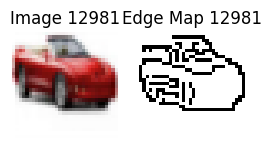

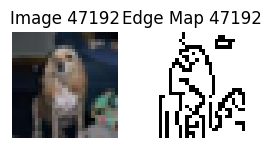

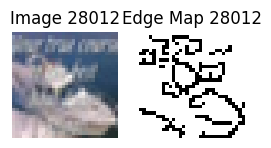

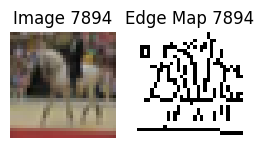

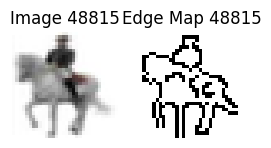

In [ ]:
# prompt: show 5 random imges from the dataset and thier edge maps

import matplotlib.pyplot as plt
import random

# Assuming train_loader is defined as in the provided code
# Get a random sample of 5 images and their edge maps from the training set
indices = random.sample(range(len(train_set)), 5)

for i in indices:
  edge_img, rgb_img = train_set[i]

  # Convert tensors to NumPy arrays for display
  edge_np = edge_img.numpy().squeeze() # Remove single-dimensional entries
  rgb_np = rgb_img.permute(1, 2, 0).numpy() # Reshape to (height, width, channels)
  rgb_np = (rgb_np + 1) / 2 # Reverse normalization for proper display

  # Display the images
  fig, axes = plt.subplots(1, 2, figsize=(3, 4))
  axes[0].imshow(rgb_np)
  axes[0].set_title(f"Image {i}")
  axes[0].axis('off')

  axes[1].imshow(edge_np, cmap='gray')
  axes[1].set_title(f"Edge Map {i}")
  axes[1].axis('off')

  plt.show()


In [ ]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down: bool = True, use_dropout: bool = False):
        super().__init__()
        layers = []

        if down:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        else:
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))

        if use_dropout:
            layers.append(nn.Dropout(0.5))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        return out

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 3):
        super().__init__()

        # Downsampling path
        self.down1 = UNetBlock(in_channels, 64, down=True, use_dropout=False)
        self.down2 = UNetBlock(64, 128, down=True, use_dropout=False)
        self.down3 = UNetBlock(128, 256, down=True, use_dropout=False)
        self.down4 = UNetBlock(256, 512, down=True, use_dropout=False)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Upsampling path
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(512 + 512, 256, down=False, use_dropout=True)
        self.up3 = UNetBlock(256 + 256, 128, down=False, use_dropout=True)
        self.up4 = UNetBlock(128 + 128, 64, down=False, use_dropout=False)

        # Final output layer
        self.final_conv = nn.ConvTranspose2d(64 + 64, out_channels, kernel_size=4, stride=2, padding=1)
        self.final_activation = nn.Tanh()

    def forward(self, x):
        # Downsample
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Bottleneck
        bottleneck = self.bottleneck(d4)

        # Upsample with skip connections
        u1 = self.up1(bottleneck)
        u1 = torch.cat([u1, d4], dim=1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d3], dim=1)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d2], dim=1)

        u4 = self.up4(u3)
        u4 = torch.cat([u4, d1], dim=1)

        # Final output
        out = self.final_conv(u4)
        out = self.final_activation(out)
        return out

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels: int = 4):
        super().__init__()
        layers = []

        # Concat edge (1ch) + image (3ch) => 4 channels
        layers.append(nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        layers.append(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(256))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        # Final convolution to produce patch output
        layers.append(nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, edge_map, image):
        # Concatenate on channel dimension
        x = torch.cat([edge_map, image], dim=1)
        output = self.model(x)
        return output

# Instantiate networks
G = GeneratorUNet().to(config["device"])
D = PatchDiscriminator().to(config["device"])

# Loss functions and optimizers
adv_criterion = nn.BCEWithLogitsLoss()
recon_criterion = nn.L1Loss()

opt_G = optim.Adam(
    G.parameters(),
    lr=config["lr"],
    betas=config["betas"]
)

opt_D = optim.Adam(
    D.parameters(),
    lr=config["lr"],
    betas=config["betas"]
)

In [ ]:
import pathlib
import json
ckpt_dir = pathlib.Path('checkpoints')
ckpt_dir.mkdir(exist_ok=True)
best_psnr = -float('inf')


def save_ckpt(epoch: int, generator: nn.Module, discriminator: nn.Module, val_psnr: float):
    # Always save latest weights
    torch.save(generator.state_dict(), ckpt_dir / 'G_last.pt')
    torch.save(discriminator.state_dict(), ckpt_dir / 'D_last.pt')
    # Write last epoch
    last_meta = {'epoch': epoch}
    (ckpt_dir / 'last_meta.json').write_text(json.dumps(last_meta))
    # Save best if improved
    global best_psnr
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(generator.state_dict(), ckpt_dir / 'G_best.pt')
        torch.save(discriminator.state_dict(), ckpt_dir / 'D_best.pt')
        best_meta = {'epoch': epoch, 'psnr': val_psnr}
        (ckpt_dir / 'best_meta.json').write_text(json.dumps(best_meta, indent=2))
        print(f"🟢 New best PSNR: {val_psnr:.2f} at epoch {epoch}")

# Resume training
last_meta_path = ckpt_dir / 'best_meta.json'
if last_meta_path.exists():
    meta = json.loads(last_meta_path.read_text())
    start_epoch = meta['epoch'] + 1
    G.load_state_dict(torch.load(ckpt_dir / 'G_last.pt', map_location=config['device']))
    D.load_state_dict(torch.load(ckpt_dir / 'D_last.pt', map_location=config['device']))
    print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 1

Resuming from epoch 43


Epoch 42/50: 100%|██████████| 196/196 [01:16<00:00,  2.55it/s]


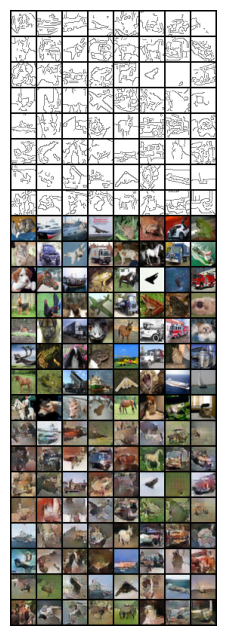

Epoch 42: Val PSNR = 11.84 dB
🟢 New best PSNR: 11.84 at epoch 42


Epoch 45/50: 100%|██████████| 196/196 [01:17<00:00,  2.54it/s]


Epoch 45: Train D Loss = 0.3556, G Loss = 27.4871


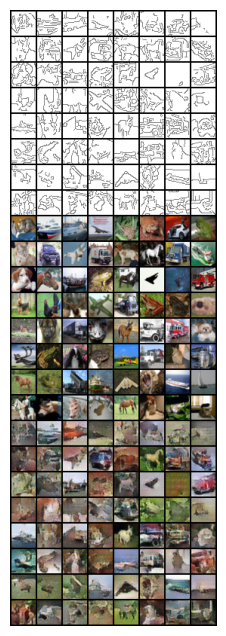

Epoch 45: Val PSNR = 11.66 dB


Epoch 48/50: 100%|██████████| 196/196 [01:17<00:00,  2.53it/s]


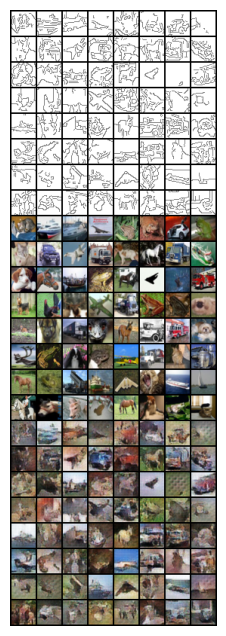

Epoch 48: Val PSNR = 11.77 dB


Epoch 50/50: 100%|██████████| 196/196 [01:17<00:00,  2.53it/s]

Epoch 50: Train D Loss = 0.3909, G Loss = 26.8427


In [ ]:
fixed_edges, fixed_real = next(iter(val_loader))
fixed_edges = fixed_edges.to(config['device'])
fixed_real = fixed_real.to(config['device'])

for epoch in range(start_epoch, config['num_epochs'] + 1):
    G.train()
    D.train()
    train_d_loss = 0.0
    train_g_loss = 0.0
    train_steps = 0

    for edges, real in tqdm(train_loader, desc=f"Epoch {epoch}/{config['num_epochs']}"):
        edges = edges.to(config['device'])
        real = real.to(config['device'])

        # Discriminator update
        with torch.no_grad():
            fake = G(edges)
        D_real = D(edges, real)
        D_fake = D(edges, fake.detach())
        loss_d_real = adv_criterion(D_real, torch.ones_like(D_real))
        loss_d_fake = adv_criterion(D_fake, torch.zeros_like(D_fake))
        d_loss = loss_d_real + loss_d_fake
        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # Generator update
        fake = G(edges)
        D_pred = D(edges, fake)
        loss_g_adv = adv_criterion(D_pred, torch.ones_like(D_pred))
        loss_g_l1 = recon_criterion(fake, real) * config['lambda_L1']
        g_loss = loss_g_adv + loss_g_l1
        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        train_d_loss += d_loss.item()
        train_g_loss += g_loss.item()
        train_steps += 1

    # Print training losses
    if epoch % 5 == 0:
        avg_d = train_d_loss / train_steps
        avg_g = train_g_loss / train_steps
        print(f"Epoch {epoch}: Train D Loss = {avg_d:.4f}, G Loss = {avg_g:.4f}")

    # Checkpoint, visualize, validate
    if epoch % config['save_every'] == 0 or epoch == 1:
        G.eval()
        # Visualize fixed batch
        with torch.no_grad():
            fake_val = G(fixed_edges).cpu()
        images = torch.cat([
            fixed_edges.cpu().repeat(1, 3, 1, 1),
            fixed_real.cpu(),
            fake_val
        ], dim=0)
        grid = utils.make_grid(images, nrow=8, normalize=True, value_range=(-1, 1))
        utils.save_image(grid, f"samples/epoch_{epoch}.png")
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis('off')
        plt.show()

        # Compute PSNR on fixed batch
        fake_np = (fake_val.numpy().transpose(0, 2, 3, 1) + 1) / 2
        real_np = (fixed_real.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2
        psnr_vals = [psnr(gt, gen, data_range=1.0) for gen, gt in zip(fake_np, real_np)]
        mean_psnr = np.mean(psnr_vals)
        print(f"Epoch {epoch}: Val PSNR = {mean_psnr:.2f} dB")

        # Save checkpoints
        save_ckpt(epoch, G, D, mean_psnr)

In [ ]:
psnr_scores = []
ssim_scores = []

G.eval()
with torch.no_grad():
    for e_batch, r_batch in tqdm(val_loader, desc="Evaluating Full Val Set"):
        e_batch = e_batch.to(config["device"])
        r_batch = r_batch.to(config["device"])

        f_batch = G(e_batch)

        f_np = (f_batch.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2
        r_np = (r_batch.cpu().numpy().transpose(0, 2, 3, 1) + 1) / 2

        for gen_img, gt_img in zip(f_np, r_np):
            psnr_scores.append(psnr(gt_img, gen_img, data_range=1.0))
            ssim_scores.append(ssim(gt_img, gen_img, channel_axis=2, data_range=1.0))

mean_psnr_full = np.mean(psnr_scores)
mean_ssim_full = np.mean(ssim_scores)

print(f"Mean PSNR (full val): {mean_psnr_full:.2f} dB")
print(f"Mean SSIM (full val): {mean_ssim_full:.4f}")


Evaluating Full Val Set: 100%|██████████| 157/157 [00:15<00:00, 10.44it/s]

Mean PSNR (full val): 11.71 dB
Mean SSIM (full val): 0.1820


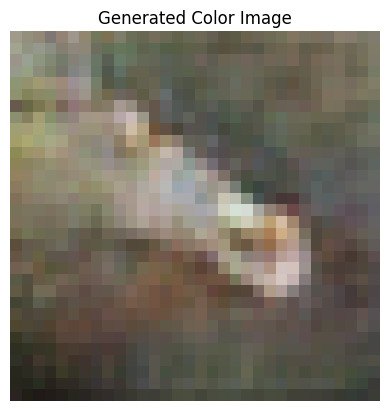

In [ ]:
from PIL import Image
import torchvision.transforms as T

sketch_path = "/content/test_image/horse.png"        # <-- update this path
sketch_img = Image.open(sketch_path).convert("L")  # grayscale

resize = T.Resize((32, 32))                     # match training resolution
to_tensor = T.ToTensor()

edge_ts = to_tensor(resize(sketch_img))          # shape: [1, H, W]
edge_ts = edge_ts.unsqueeze(0).to(config["device"])  # add batch dim

# 2. Load the Generator checkpoint
checkpoint = GeneratorUNet().to(config["device"])
ckpt = torch.load("/content/drive/MyDrive/Colab Notebooks/checkpoints/G_last.pt", map_location=config["device"])
checkpoint.load_state_dict(ckpt)
checkpoint.eval()

# 3. Run inference
with torch.no_grad():
    fake_ts = checkpoint(edge_ts)

# 4. Post-process and display
fake_img = fake_ts[0].cpu()                     # remove batch dim

# convert from [-1,1] to [0,1] and to PIL
to_pil = T.ToPILImage()
pil_img = to_pil((fake_img + 1.0) / 2.0)

import matplotlib.pyplot as plt
plt.imshow(pil_img)
plt.axis('off')
plt.title('Generated Color Image')
plt.show()